In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

sns.set_palette('rocket')
plt.rcParams['image.cmap'] = 'rocket'
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [65]:
df = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

In [66]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').set_index('Date')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3703 entries, 2008-01-02 to 2022-12-01
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Buying                3703 non-null   float64
 1   Selling               3701 non-null   float64
 2   MidRate               3701 non-null   float64
 3   MPR                   3703 non-null   float64
 4   FoodInflation         3703 non-null   float64
 5   GhInflationRate       3703 non-null   float64
 6   NonFoodInflation      3703 non-null   float64
 7   BrentOil              3703 non-null   float64
 8   Cocoa                 3703 non-null   float64
 9   Gold                  3703 non-null   float64
 10  GhInterestRate        3703 non-null   float64
 11  NetForeignAssets      3703 non-null   float64
 12  NIR                   3703 non-null   float64
 13  Imports               3703 non-null   float64
 14  Exports               3703 non-null   float64
 15  GhG

In [68]:
TARGET = 'Buying'
DROP_COLUMNS = [TARGET, 'Selling', 'MidRate']

In [69]:
df.drop(columns=['InterbankWeightedAvg', 'NonFoodInflation', 'FoodInflation', 'MPR', 'T-bill-182'], inplace=True)

In [70]:
# Initialize a list of all raw features we want to keep
FEATURES = df.drop(columns=DROP_COLUMNS).columns.tolist()

In [71]:
FEATURES

['GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'GhCompositeIndex',
 'FXDeposits',
 'T-bill-91',
 'PrivateSectorCredit',
 'TradeBalance',
 'USGDP',
 'USInflationRate',
 'USInterestRate']

In [72]:
LAGS  = [5, 20, 60] # Lags for 1 week, 1 month, 1 quarter

##### Lagged Features for Target (Short- & Medium-Term Momentum)

In [73]:
for lag in LAGS:
    column_name = f'{TARGET}Lag{lag}d'
    df[column_name] = df[TARGET].shift(lag)
    FEATURES.append(column_name)

##### Economic Differentials (Fundamental Drivers)

In [74]:
# Interest Rate Parity (IRP)
df['InterestRateDifferential'] = df['GhInterestRate'] - df['USInterestRate']
FEATURES.append('InterestRateDifferential')

# Purchasing Power Parity (PPP)
df['InflationDifferential'] = df['GhInflationRate'] - df['USInflationRate']
FEATURES.append('InflationDifferential')

# Trade Balance (Currency Flow)
df['TradeBalance'] = df['Exports'] - df['Imports']
FEATURES.append('TradeBalance')

In [75]:
# C. Time-based Features (Cyclicality)
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
# Binary feature for structural month-end flows
df['IsMonthEnd'] = df.index.is_month_end.astype(int)
FEATURES.extend(['DayOfWeek', 'DayOfYear', 'IsMonthEnd'])

In [76]:
# D. Growth Rates for Low-Frequency Data (Economic Momentum)
# Use 65-day shift as a proxy for Quarter-over-Quarter (QoQ) Growth
QUARTERLY_SHIFT = 65
df['GhGDPQoQGrowth'] = (
    df['GhGDP'] / df['GhGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
df['USGDPQoQGrowth'] = (
    df['USGDP'] / df['USGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
FEATURES.extend(['GhGDPQoQGrowth', 'USGDPQoQGrowth'])

##### Final Data Preparation and Split 

In [77]:
[TARGET] + FEATURES

['Buying',
 'GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'GhCompositeIndex',
 'FXDeposits',
 'T-bill-91',
 'PrivateSectorCredit',
 'TradeBalance',
 'USGDP',
 'USInflationRate',
 'USInterestRate',
 'BuyingLag5d',
 'BuyingLag20d',
 'BuyingLag60d',
 'InterestRateDifferential',
 'InflationDifferential',
 'TradeBalance',
 'DayOfWeek',
 'DayOfYear',
 'IsMonthEnd',
 'GhGDPQoQGrowth',
 'USGDPQoQGrowth']

In [78]:
# Drop initial rows with NaN values created by lagging/growth rate calculations
df_clean = df.dropna(subset=[TARGET] + FEATURES)

In [79]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3638 entries, 2008-04-08 to 2022-12-01
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Buying                    3638 non-null   float64
 1   Selling                   3636 non-null   float64
 2   MidRate                   3636 non-null   float64
 3   GhInflationRate           3638 non-null   float64
 4   BrentOil                  3638 non-null   float64
 5   Cocoa                     3638 non-null   float64
 6   Gold                      3638 non-null   float64
 7   GhInterestRate            3638 non-null   float64
 8   NetForeignAssets          3638 non-null   float64
 9   NIR                       3638 non-null   float64
 10  Imports                   3638 non-null   float64
 11  Exports                   3638 non-null   float64
 12  GhGDP                     3638 non-null   float64
 13  GhCompositeIndex          3638 non-null   flo

In [81]:
df_clean.drop(columns=['Selling', 'MidRate'], inplace=True)

/var/folders/pq/lv4328kx4fjg40sltdfjtrcm0000gn/T/ipykernel_57152/329433199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['Selling', 'MidRate'], inplace=True)


In [82]:
# Finalize feature list by intersecting with available columns
FINAL_FEATURES = [f for f in FEATURES if f in df_clean.columns]

In [83]:
FINAL_FEATURES

['GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'GhCompositeIndex',
 'FXDeposits',
 'T-bill-91',
 'PrivateSectorCredit',
 'TradeBalance',
 'USGDP',
 'USInflationRate',
 'USInterestRate',
 'BuyingLag5d',
 'BuyingLag20d',
 'BuyingLag60d',
 'InterestRateDifferential',
 'InflationDifferential',
 'TradeBalance',
 'DayOfWeek',
 'DayOfYear',
 'IsMonthEnd',
 'GhGDPQoQGrowth',
 'USGDPQoQGrowth']

In [84]:
x = df_clean[FINAL_FEATURES]
y = df_clean[TARGET]

print(
    f"Data ready. Total features: {len(FINAL_FEATURES)}, Cleaned data shape: {x.shape}")

Data ready. Total features: 29, Cleaned data shape: (3638, 29)


##### Model Setup and Hyperparameter Tuning (Grid Search)

In [85]:
# Time-Series Split (Walk-Forward Validation)
# The training set grows with each fold, respecting the temporal order.
time_series_split = TimeSeriesSplit(n_splits=5)

In [86]:
# Gradient Boosting Regressor baseline model
gbr = GradientBoostingRegressor(random_state=42)

In [87]:
# Hyperparameter Grid: Focused search based on best practices
parameter_grid = {
    'n_estimators': [100, 200],     # Number of trees (Complexity)
    'learning_rate': [0.05, 0.1],   # Step size shrinkage (Regularization)
    'max_depth': [3, 5],            # Depth of individual trees (Complexity)
    'subsample': [0.7, 0.9]         # Stochasticity (Regularization)
}

In [88]:
# Grid Search setup (optimizing for the robust Mean Squared Error)
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=parameter_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,  # Use TimeSeriesSplit
    verbose=2,
    n_jobs=-1
)

In [89]:
print("\nStarting Grid Search with TimeSeriesSplit (Walk-Forward Validation)...")
grid_search.fit(x, y)


Starting Grid Search with TimeSeriesSplit (Walk-Forward Validation)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, 

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], 'subsample': [0.7, 0.9]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [90]:
# Retrieve the best model found
best_gbr = grid_search.best_estimator_

In [91]:
# Predict using the best model on the training data (for evaluation metrics)
y_predictions = best_gbr.predict(x)

In [92]:
# Calculate final metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
rmse = root_mean_squared_error(y, y_predictions)
np_rmse = np.sqrt(mse)
r2 = r2_score(y, y_predictions)

In [93]:
evaluation_results = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'np.sqrt(MSE)', 'R2'],
    'Value': [mae, mse, rmse, np_rmse, r2]
})

evaluation_results

,Metric,Value
0,MAE,0.014597
1,MSE,0.002468
2,RMSE,0.049674
3,np.sqrt(MSE),0.049674
4,R2,0.999421


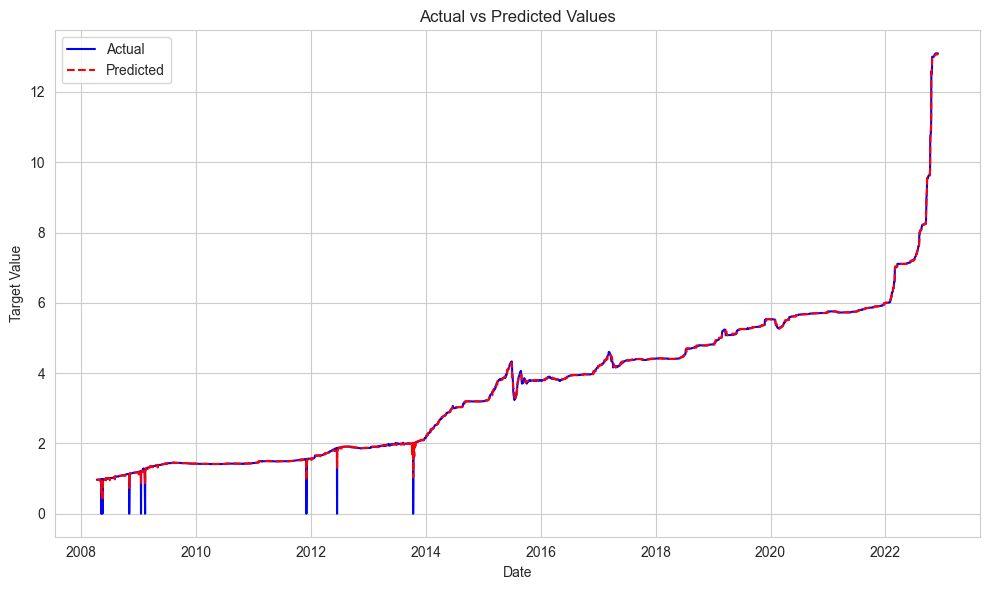

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='b')
plt.plot(y.index, y_predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Date' if hasattr(y.index, 'dtype') and 'datetime' in str(y.index.dtype) else 'Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.savefig('plots/gb/actual_vs_predicted.png')
plt.show()


#### LSTM

In [95]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning specific imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner import RandomSearch

In [96]:
# --- Global Configurations ---
TARGET = 'Buying'
# CRITICAL CHANGE: Increase lookback to capture monthly economic cycles
TIMESTEPS = 60
SPLIT_DATE = '2023-01-01'

In [97]:
# --- 1. Data Loading and Feature Engineering (Log Returns for Stationarity) ---
df = pd.read_csv("datasets/cleaned/merged_fx_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').set_index('Date')

In [98]:
# New Target: Daily Log Return (for better stationarity)
df['Log_Return'] = np.log(df[TARGET] / df[TARGET].shift(1))
NEW_TARGET = 'Log_Return'

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [99]:
# Feature Engineering
DROP_COLS = [TARGET, 'Selling', 'MidRate', NEW_TARGET]

# Initialize feature list with raw columns
FEATURES = df.drop(columns=DROP_COLS).columns.tolist()

# Add engineered features (same as before)
df['InterestRate_Diff'] = df['GhInterestRate'] - df['USInterestRate']
df['Inflation_Diff'] = df['GhInflationRate'] - df['USInflationRate']
df['Trade_Balance'] = df['Exports'] - df['Imports']
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
df['Is_Month_End'] = df.index.is_month_end.astype(int)
QUARTERLY_SHIFT = 65
df['GhGDP_QoQ_Growth'] = (
    df['GhGDP'] / df['GhGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
df['USGDP_QoQ_Growth'] = (
    df['USGDP'] / df['USGDP'].shift(QUARTERLY_SHIFT) - 1) * 100

In [100]:
FEATURES.extend(['InterestRate_Diff', 'Inflation_Diff', 'Trade_Balance',
                 'DayOfWeek', 'DayOfYear', 'Is_Month_End',
                 'GhGDP_QoQ_Growth', 'USGDP_QoQ_Growth'])

In [101]:
# Finalize data and remove NaNs (handle the shift(1) from Log_Return)
df_clean = df.dropna(subset=[NEW_TARGET] + FEATURES)
FINAL_FEATURES = [f for f in FEATURES if f in df_clean.columns]

x_data = df_clean[FINAL_FEATURES].values
y_data = df_clean[NEW_TARGET].values.reshape(-1, 1)

In [102]:
x_data.shape, y_data.shape

((3638, 31), (3638, 1))

In [103]:
# --- 2. Sequence Creation ---
def create_sequences(x, y, timesteps):
    x_seq, y_seq = [], []
    for i in range(len(x) - timesteps):
        x_seq.append(x[i:i + timesteps, :])
        y_seq.append(y[i + timesteps, 0])
    return np.array(x_seq), np.array(y_seq)


x_seq_full, y_seq_full = create_sequences(x_data, y_data, TIMESTEPS)

In [104]:
# --- 3. Time-Based Train/Test Split (CRITICAL FIX) ---
split_idx = df_clean.index.get_indexer([SPLIT_DATE], method='ffill')[0]

# We split the raw data before scaling to avoid leakage
x_train_raw, x_test_raw = x_data[:split_idx], x_data[split_idx:]
y_train_raw, y_test_raw = y_data[:split_idx], y_data[split_idx:]

In [105]:
# --- 4. Scaling (FIXED: Fit only on Train, Transform All) ---
# Fit scalers ONLY on the training data
scaler_x = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler_x.fit_transform(x_train_raw)
# Transform test data using train stats
x_test_scaled = scaler_x.transform(x_test_raw)

scaler_y = MinMaxScaler(feature_range=(0, 1))
# Check for and handle any infinite or very large values before fitting the scaler
y_train_clean = np.where(np.isfinite(y_train_raw), y_train_raw, np.nan)
# Optionally, replace NaN/infinite with the column median (or zeros, or drop, depending on your needs)
if np.isnan(y_train_clean).any():
    median_val = np.nanmedian(y_train_clean)
    y_train_clean = np.where(np.isnan(y_train_clean), median_val, y_train_clean)
y_train_scaled = scaler_y.fit_transform(y_train_clean)

# Transform test data using train stats
y_test_scaled = scaler_y.transform(y_test_raw)

# Re-create sequences from the correctly scaled data
x_train_seq, y_train_seq = create_sequences(
    x_train_scaled, y_train_scaled, TIMESTEPS)
x_test_seq, y_test_seq = create_sequences(
    x_test_scaled, y_test_scaled, TIMESTEPS)

N_FEATURES = x_train_seq.shape[2]
print(f"Data Prepared. x_train_seq shape: {x_train_seq.shape}")

Data Prepared. x_train_seq shape: (3577, 60, 31)


In [106]:
# --- 5. Keras Tuner Model Definition Function (Reused) ---
def build_model(hp):
    model = Sequential()

    num_lstm_layers = hp.Int(
        'num_lstm_layers', min_value=1, max_value=2, step=1)

    for i in range(num_lstm_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            return_sequences=(i < num_lstm_layers - 1),
            input_shape=(TIMESTEPS, N_FEATURES) if i == 0 else None
        ))
        model.add(
            Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

In [107]:
# --- 6. Hyperparameter Search (Random Search with TimeSeriesSplit) ---
tscv = TimeSeriesSplit(n_splits=3)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_fx_fixed',
    project_name='lstm_fx_tuning_fixed',
    overwrite=True
)

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
# Perform Walk-Forward Search
for fold, (train_index, val_index) in enumerate(tscv.split(x_train_seq)):
    print(f"\n--- Fitting Fold {fold+1} ---")

    x_train_fold, x_val_fold = x_train_seq[train_index], x_train_seq[val_index]
    y_train_fold, y_val_fold = y_train_seq[train_index], y_train_seq[val_index]

    tuner.search(
        x_train_fold, y_train_fold,
        epochs=15,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5)]
    )

Trial 10 Complete [00h 00m 11s]
val_loss: 0.005688886158168316

Best val_loss So Far: 0.0013349923538044095
Total elapsed time: 00h 03m 36s

--- Fitting Fold 2 ---

--- Fitting Fold 3 ---


In [109]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nOptimal Hyperparameters Found: {best_hps.values}")

# --- 7. Final Model Training and Evaluation ---
final_model = tuner.hypermodel.build(best_hps)

print("\nTraining final model on full fixed training set...")
final_model.fit(
    x_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(x_test_seq, y_test_seq),
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# Predict on the hold-out test set
y_pred_scaled = final_model.predict(x_test_seq)


Optimal Hyperparameters Found: {'num_lstm_layers': 2, 'units_0': 32, 'dropout_0': 0.5, 'learning_rate': 0.01, 'units_1': 128, 'dropout_1': 0.1}

Training final model on full fixed training set...


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 60, 31), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
# Inverse transform predictions and actuals to original Log Return scale
y_test_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

# Calculate final metrics on the Log Returns
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print("\n" + "="*50)
print("--- Final Model Evaluation (LSTM - FIXED) on Test Set ---")
print("Target: Daily Log Returns (Stationary)")
print(f"TimeSteps (Lookback Window): {TIMESTEPS} days")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.4f}")
print(
    f"R-squared Target Achievement: {'ACHIEVED' if r2 >= 0.70 else 'NOT ACHIEVED'}")
print("="*50)


--- Final Model Evaluation (LSTM - FIXED) on Test Set ---
Target: Daily Log Returns (Stationary)
TimeSteps (Lookback Window): 60 days
--------------------------------------------------
Mean Absolute Error (MAE): 0.002533
Root Mean Squared Error (RMSE): 0.003429
R-squared (R²): -0.6022
R-squared Target Achievement: NOT ACHIEVED
